## Meta learning + Prototypical networks for HAR

### 현재 코드에서의 학습 방법

| 단계 | 프로세스 | 상세 설명 (행동 예시 포함) |
| :--- | :--- | :--- |
| **1. 태스크(Task) 샘플링** | **'N-Way K-Shot' 모의고사 출제** | 훈련 사용자(18명) 중에서 무작위로 **`N`개의 행동**(예: `N=3`일 때, 'Walking', 'Sitting', 'Laying')을 선택합니다.<br><br>그다음, 이 3개 행동에 대해 **`K`개**의 힌트와 **`Q`개**의 문제를 뽑습니다.<br><br> **- 서포트 셋 (Support Set, K):** `K=5`라면, 'Walking' 5개, 'Sitting' 5개, 'Laying' 5개의 샘플을 **힌트**로 추출합니다. (`support_x`)<br> **- 쿼리 셋 (Query Set, Q):** `Q=15`라면, 위 힌트와 **겹치지 않는** 'Walking' 15개, 'Sitting' 15개, 'Laying' 15개의 샘플을 **시험 문제**로 추출합니다. (`query_x`)<br><br>이 {Support Set, Query Set}의 쌍이 하나의 **태스크(Task)**, 즉 1회차 모의고사입니다. |
| **2. 태스크 적응 (Prototype Computation)** | **'힌트(K)'로 클래스별 대표 특징 계산** | 모델(`Encoder`)은 1단계의 **서포트 셋(`support_x`)**만 봅니다.<br><br> **- 'Walking' 프로토타입 생성:** 힌트로 주어진 5개의 'Walking' 샘플을 `Encoder`로 임베딩(압축)한 뒤, 5개 임베딩의 **평균**을 냅니다. 이 평균 벡터가 "이번 태스크 전용 'Walking'의 대표 특징"이 됩니다.<br> **- 'Sitting', 'Laying' 프로토타입 생성:** 'Sitting'과 'Laying'도 5개씩의 힌트 샘플을 각각 평균 내어 "이번 태스크 전용 프로토타입"을 만듭니다.<br><br>이 과정이 태스크 적응(Adaptation)이며, `N`개의 프로토타입이 "이번 태스크 전용 분류기"가 됩니다. |
| **3. 메타-목표(Meta-Objective) 평가** | **'시험 문제(Q)'를 풀고 채점(Loss 계산)** | 모델은 1단계의 **쿼리 셋(`query_x`)**을 봅니다.<br><br> **- 문제 풀이 (예측):** 쿼리 셋의 15개 'Walking' 샘플 각각을 2단계에서 만든 3개의 프로토타입('Walking', 'Sitting', 'Laying')과 **코사인 유사도**를 비교합니다. 15개의 샘플 모두 'Walking' 프로토타입과 가장 유사도가 높게 나와야 정답입니다.<br> **- 채점 (손실 계산):** 쿼리 셋 전체(45개)의 예측값과 실제 정답(`query_y`)을 비교하여 **Cross-Entropy Loss (손실)**를 계산합니다.<br><br>이 손실은 "모델이 K개의 힌트만 보고 프로토타입을 *얼마나 잘* 만들었는가"를 나타내는 **메타-목표** 점수입니다. |
| **4. 메타-파라미터(Meta-Parameter) 최적화** | **'오답(Loss)'을 바탕으로 `Encoder` 전략 수정** | 3단계에서 계산된 **손실(Loss)**을 `Encoder`의 가중치(파라미터)에 대해 역전파(Backpropagation)합니다.<br><br> **- (핵심)** 이 업데이트는 "방금 15개의 'Walking' 문제를 맞추는" `Encoder`를 만드는 것이 아닙니다.<br> **-** 대신 **"미래에 *어떤* 'Walking' 샘플 5개(K)가 힌트로 주어지더라도, 처음 보는 'Walking' 문제(Q)를 잘 맞출 수 있는 *범용적인* 프로토타입을 생성해내는"** `Encoder`를 만들도록 전략(가중치)을 수정합니다.<br><br>이 1~4단계를 2000회 반복하며, 모델은 **"적응하는 방법(Learning to Adapt)"** 자체를 학습합니다. |



### 기존 학습 방법과의 비교

- Reference : https://huidea.tistory.com/252

- Supervised Learning (SL): **"하나의 특정 작업(Task)"** 을 잘하는 모델을 만듭니다.
  - 예시: 30명 전부의 데이터를 합쳐서, '걷기'와 '앉기'를 구별하는 단 하나의 완벽한 모델을 학습시킵니다.

- Meta-Learning (ML): **"새로운 작업을 빠르게 학습하는 방법"** 자체를 학습합니다.
  - 예시: "처음 보는 사용자"의 데이터 5개(K-shot)만 보고도, 이 사람만을 위한 분류기(Prototype)를 즉시 만들어내는 **방법**을 배웁니다.


### 테스트 목록

| 용어 (Term) | 학술적 정의 | 코드 내 역할 및 프로세스 |
| :--- | :--- | :--- |
| **K (K-Shot)** | **태스크 적응(Task-Specific Adaptation)을 위한 샘플** | `K`는 `k_shot`으로 표현되며, 각 클래스(N-Way)에서 추출되는 **Support Set (지원 집합)**의 샘플 수를 의미합니다.<br><br>Prototypical Network에서 이 `K`개의 샘플(`support_x`)은 **태스크별 분류기(프로토타입)**를 생성하는 데 사용됩니다.<br><br>**프로세스:**<br>1. `K` * `N`개의 `support_x` 데이터가 `Encoder`를 통과하여 임베딩(Embedding)으로 변환됩니다.<br>2. `compute_prototypes` 함수는 동일 클래스에 속하는 `K`개의 임베딩을 **평균(mean)**하여 해당 클래스의 **프로토타입(Prototype)**, 즉 대표 벡터를 계산합니다.<br>3. 이 프로토타입 자체가 이 태스크에 **적응(adaptation)**된 분류기의 역할을 수행합니다. |
| **Q (Q-Query)** | **적응된 모델의 성능 평가를 위한 샘플** | `Q`는 `q_query`로 표현되며, 각 클래스(N-Way)에서 Support Set과 **겹치지 않게(disjoint)** 추출되는 **Query Set (질의 집합)**의 샘플 수를 의미합니다.<br><br>이 `Q`개의 샘플(`query_x`)은 Support Set으로 생성된 프로토타입(분류기)의 성능을 평가하고, **메타-옵티마이저(meta-optimizer)**의 손실(Loss)을 계산하는 데 사용됩니다.<br><br>**프로세스:**<br>1. `Q` * `N`개의 `query_x` 데이터가 `Encoder`를 통과하여 쿼리 임베딩으로 변환됩니다.<br>2. 이 쿼리 임베딩은 `K`로 계산된 프로토타입들과의 **코사인 유사도(Cosine Similarity)**를 계산하는 데 사용됩니다.<br>3. **학습(`meta_train`) 시:** 이 유사도(Logits)와 실제 `query_y` 레이블 간의 **Cross-Entropy Loss**가 계산되며, 이 Loss가 `Encoder`의 파라미터를 업데이트(학습)하는 기준이 됩니다.<br>4. **테스트(`meta_test`) 시:** 이 유사도를 기반으로 한 예측 정확도(Accuracy, F1-Score 등)가 모델의 **최종 Few-Shot 성능**으로 기록됩니다. |

| 구분 | 설명 | 상세 내용 |
| :--- | :--- | :--- |
| **1. 메타-러닝(Meta-Learning)이란?** | **"학습하는 방법"을 학습<br>(Learning to Learn)** | 메타-러닝의 목표는 하나의 고정된 작업을 잘하는 모델을 만드는 것이 아닙니다.<br>그 대신, **새로운 작업**이 주어졌을 때 **아주 적은 데이터(Few-Shot)**만 보고도 **빠르게 적응**할 수 있는 모델을 만드는 것이 궁극적인 목표입니다.<br>따라서 학습 단위도 개별 데이터 샘플이 아니라, '태스크(Task)' 또는 '에피소드(Episode)' 단위로 학습이 진행됩니다. (예: "5개의 힌트로 15개 문제 맞추기"라는 모의고사 자체를 하나의 학습 단위로 봄) |
| **2. 현재 코드의 학습 과정**<br/>(LSSO 방식: 18명으로 학습) | **'모의고사(Episode)'를 반복 풀며<br>적응 전략을 학습** | 학습은 '에피소드'라는 모의고사를 푸는 과정의 연속입니다.<br>먼저 훈련 사용자 18명 중에서 무작위로 **N개 클래스**를 선택합니다.<br>그다음, 각 클래스에서 **K개 힌트(Support Set)**와 **Q개 문제(Query Set)**를 뽑아 하나의 '모의고사'를 만듭니다.<br>모델의 `Encoder`는 **Support Set(힌트)**을 입력받아 임베딩(특징 벡터)으로 압축하고, 같은 클래스끼리 평균을 내어 클래스별 **프로토타입**(대표 벡터)을 계산합니다.<br>이후 `Encoder`가 **Query Set(문제)**을 임베딩하고, 이 임베딩과 각 프로토타입 간의 **코사인 유사도**를 계산하여 가장 유사도가 높은 클래스로 예측합니다.<br>마지막으로 **Query Set의 예측값**과 실제 정답 간의 손실(Loss)을 계산하여, 이 오차를 줄이는 방향으로 **`Encoder`의 가중치를 업데이트**합니다.<br>이 모든 과정을 2000 에피소드만큼 반복하며, "어떤 힌트(Support)가 주어져도 프로토타입을 잘 만드는 `Encoder`"를 훈련시킵니다. |
| **3. 학습 후 테스트 과정**<br/>(9명 / 30명으로 평가) | **"완전히 처음 보는 사용자"에게<br>적응하는 능력을 평가** | 학습이 완료된 모델을 "완전히 처음 보는" 사용자에게 테스트하며 적응 능력을 평가합니다.<br><br>**A. LSSO 테스트 (9명 대상):**<br>훈련된 단일 모델로 9명의 테스트 유저에게 여러 실험을 진행합니다.<br> **- K-Shot Ablation:** 적응용 데이터(K)가 1, 3, 5, 10, 20개일 때의 성능 변화를 평가합니다. (힌트가 많을수록 잘하는가?)<br> **- N-Way Ablation:** 문제 난이도(N)가 3~6-Way일 때의 성능 변화를 평가합니다. (문제가 어려워도 잘 푸는가?)<br> **- Per-User Test:** 9명의 테스트 유저 **각각**에 대해 5-Shot 적응 성능을 개별 측정하여 평균과 편차를 봅니다. (개인화 성능)<br><br>**B. LOSO 테스트 (30명 전체 대상):**<br>가장 엄격한 최종 검증입니다.<br>**30명의 사용자 각각을 한 번씩 테스트용으로 제외**하고, 나머지 29명(혹은 28명)의 데이터로 모델을 **처음부터 다시 학습**시킵니다. (총 30번 학습/평가 반복)<br>이렇게 얻어진 30명 전원의 개별 5-Shot 테스트 성능(Accuracy, F1, Precision, Recall)을 **전부 `display(df)`로 출력**하고, 30명 전체의 최종 평균 성능을 도출합니다. |

In [1]:
!pip install thop ptflops

Device: cuda

LOADING UCI HAR DATASET
Data shape: (10299, 128, 9)
Labels: ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying']
Total subjects: 30

Train subjects: 18 users
Val subjects: 3 users
Test subjects: 9 users

Train samples: 5817
Val samples: 1122
Test samples: 3360

BUILDING PROTOTYPE NETWORK (COSINE SIMILARITY)

MODEL ARCHITECTURE & PERFORMANCE STATS


,Metric,Value
0,Parameters (M),0.37
1,FLOPs (M),5.36
2,Inference Time (ms),3.84



META-TRAINING WITH VALIDATION
Episode    0 | Loss: 0.5486 | Train Acc: 0.8444 | Val Acc: 0.1711
Episode  200 | Loss: 0.0690 | Train Acc: 0.9667 | Val Acc: 0.9678
Episode  400 | Loss: 0.2279 | Train Acc: 0.9333 | Val Acc: 0.9772
Episode  600 | Loss: 0.1448 | Train Acc: 0.9222 | Val Acc: 0.9861
Episode  800 | Loss: 0.1459 | Train Acc: 0.8667 | Val Acc: 0.9667
Episode 1000 | Loss: 0.0033 | Train Acc: 1.0000 | Val Acc: 0.9867
Episode 1200 | Loss: 0.0312 | Train Acc: 1.0000 | Val Acc: 0.9883
Episode 1400 | Loss: 0.0172 | Train Acc: 1.0000 | Val Acc: 0.9778
Episode 1600 | Loss: 0.0272 | Train Acc: 0.9889 | Val Acc: 0.9911
Episode 1800 | Loss: 0.0328 | Train Acc: 1.0000 | Val Acc: 0.9994

GENERATING LEARNING CURVES


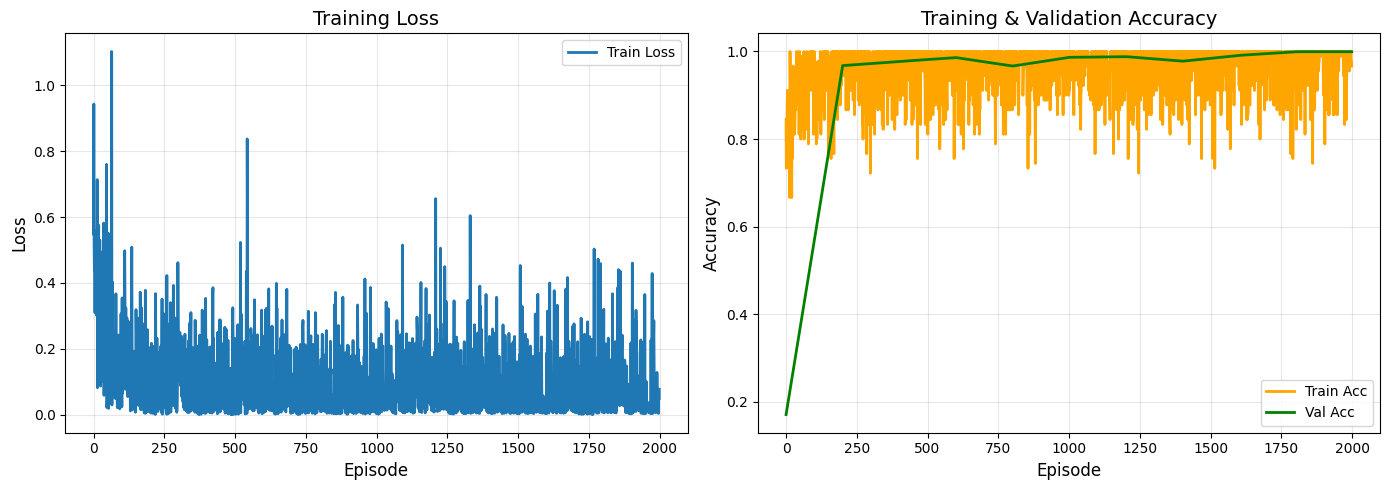

Displayed: learning_curves.png

META-TESTING: 5-WAY, 5-SHOT PERFORMANCE

OVERALL RESULTS:


,Metric,Value
0,Accuracy,0.9763
1,F1-Score (macro),0.9763
2,Precision (macro),0.9764
3,Recall (macro),0.9763
4,Parameters (M),0.37
5,FLOPs (M),5.36
6,Inference Time (ms),3.84



PER-CLASS ACCURACY:


,Class,Accuracy
0,Walking,0.9733
1,Walking Upstairs,0.9793
2,Walking Downstairs,0.9720
3,Sitting,0.9883
4,Standing,0.9740
5,Laying,0.9710


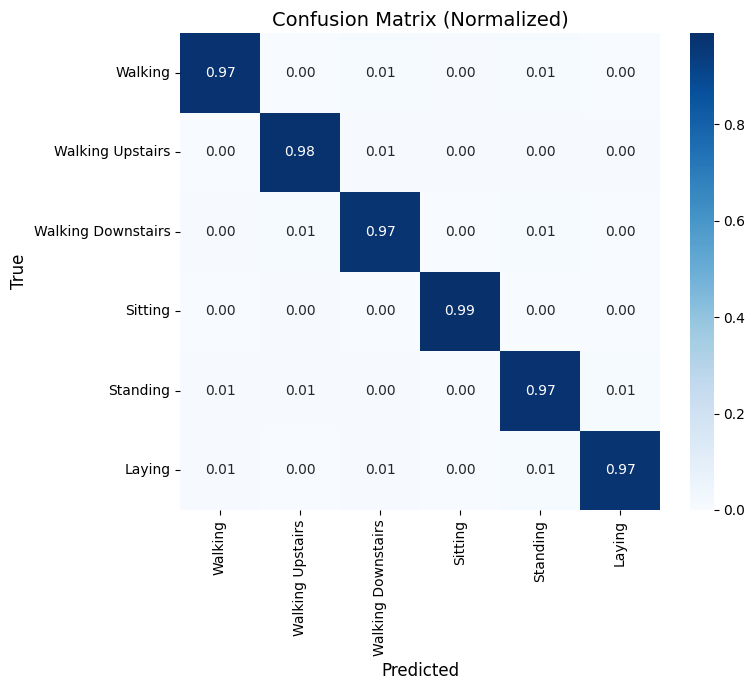


Displayed: cm_5shot.png

K-SHOT ABLATION STUDY
Testing 1-shot...
Testing 3-shot...
Testing 5-shot...
Testing 10-shot...
Testing 20-shot...

K-SHOT COMPARISON:


,K-Shot,Accuracy,F1,Precision,Recall
0,1,0.9683,0.9683,0.9684,0.9683
1,3,0.9688,0.9687,0.9687,0.9688
2,5,0.9782,0.9782,0.9783,0.9782
3,10,0.9820,0.9820,0.9820,0.9820
4,20,0.9809,0.9809,0.9810,0.9809


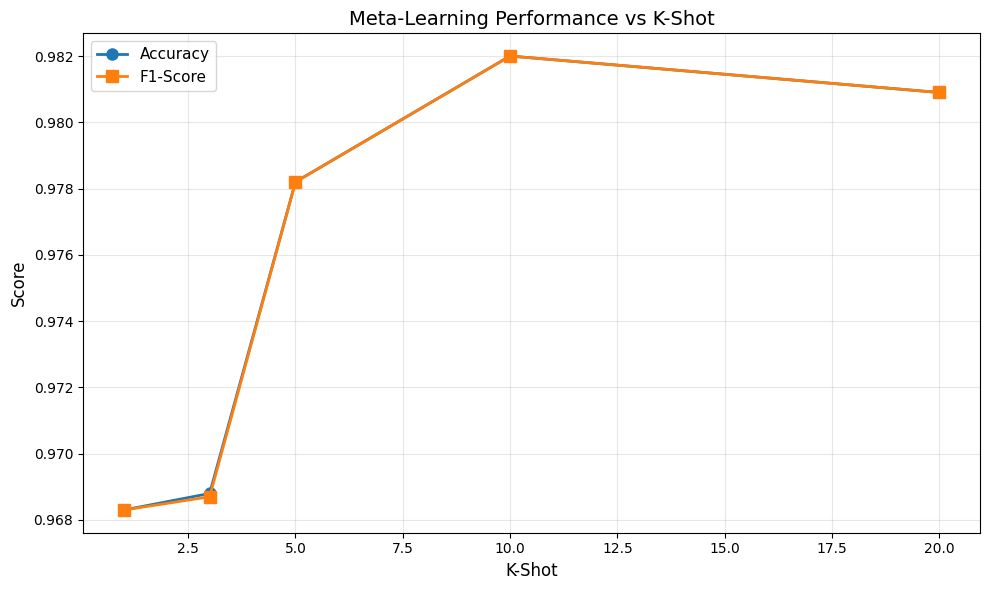


Displayed: kshot_comparison.png

N-WAY ABLATION STUDY
Testing 3-way...
Testing 4-way...
Testing 5-way...
Testing 6-way...

N-WAY COMPARISON:


,N-Way,Accuracy,F1,Precision,Recall
0,3,0.9891,0.9891,0.9891,0.9891
1,4,0.9913,0.9913,0.9914,0.9913
2,5,0.9839,0.9839,0.9839,0.9839
3,6,0.9768,0.9768,0.9768,0.9768



QUERY SET SIZE ABLATION
Testing query=5...
Testing query=10...
Testing query=15...
Testing query=20...
Testing query=25...

QUERY SIZE COMPARISON:


,Query Size (q),Accuracy,F1,Precision,Recall
0,5,0.9807,0.9807,0.9807,0.9807
1,10,0.9762,0.9762,0.9763,0.9762
2,15,0.9824,0.9825,0.9825,0.9824
3,20,0.9724,0.9724,0.9724,0.9724
4,25,0.9761,0.9761,0.9762,0.9761



PER-USER PERSONALIZATION (ON TEST SET)


,User,Accuracy,F1,Precision,Recall
0,22,1.0000,1.0000,1.0000,1.0000
1,23,0.9759,0.9759,0.9760,0.9759
2,24,1.0000,1.0000,1.0000,1.0000
3,25,0.9781,0.9781,0.9782,0.9781
4,26,1.0000,1.0000,1.0000,1.0000
5,27,1.0000,1.0000,1.0000,1.0000
6,28,0.9100,0.9100,0.9107,0.9100
7,29,0.9833,0.9833,0.9835,0.9833
8,30,0.9289,0.9287,0.9290,0.9289



Mean User Accuracy (Test Set): 0.9751 ± 0.0315


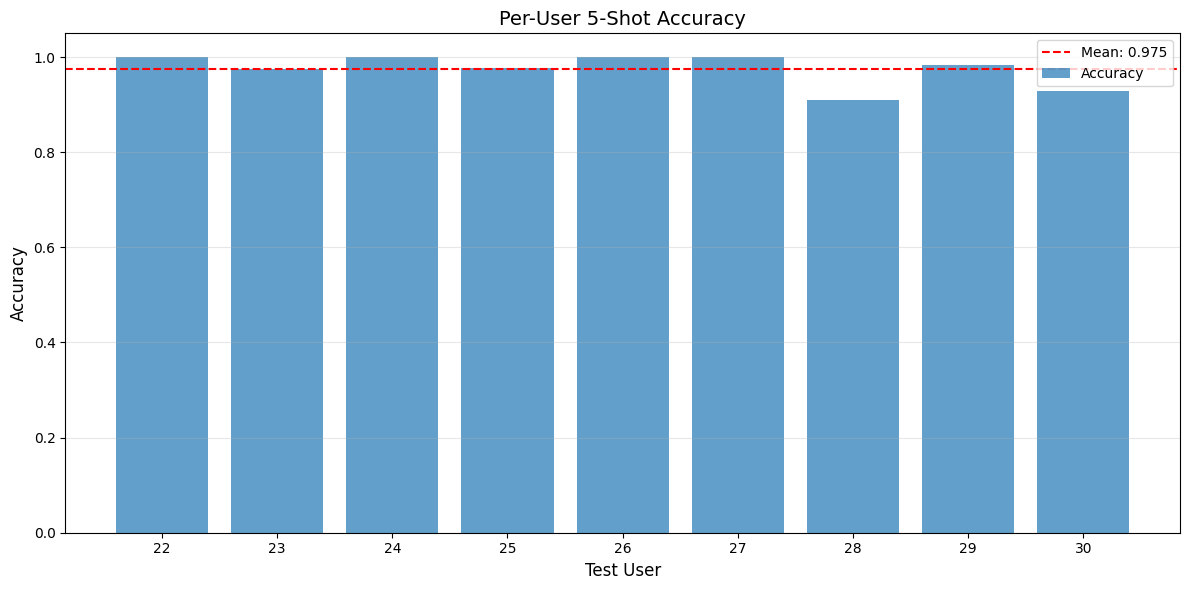

Displayed: user_performance.png

FINAL SUMMARY (LSSO SPLIT)


,Experiment,Result
0,Model Parameters (M),0.37
1,Model FLOPs (M),5.36
2,"Inference Time (ms, 6W-5S)",3.84
3,"5-Shot, 6-Way Test Accuracy",0.9763
4,"5-Shot, 6-Way Test F1",0.9763
5,"1-Shot, 6-Way Accuracy",0.9683
6,"20-Shot, 6-Way Accuracy",0.9809
7,"5-Shot, 3-Way Accuracy",0.9891
8,Mean User Accuracy (Test Set),0.9751



STARTING LEAVE-ONE-SUBJECT-OUT (LOSO) EXPERIMENT
Total Subjects: 30. This will run 30 training sessions.

--- LOSO Run 1/30: Testing on User 1 ---
Meta-Training for User 1...
Episode    0 | Loss: 1.3956 | Train Acc: 0.7444 | Val Acc: 0.1883
Episode  500 | Loss: 0.9664 | Train Acc: 0.9889 | Val Acc: 0.9761
Episode 1000 | Loss: 0.9259 | Train Acc: 1.0000 | Val Acc: 0.8828
Episode 1500 | Loss: 0.9423 | Train Acc: 0.9889 | Val Acc: 0.9022
Meta-Testing on User 1...

--- LOSO Run 2/30: Testing on User 2 ---
Meta-Training for User 2...
Episode    0 | Loss: 1.5502 | Train Acc: 0.6111 | Val Acc: 0.1883
Episode  500 | Loss: 0.9676 | Train Acc: 0.8889 | Val Acc: 0.9000
Episode 1000 | Loss: 0.9677 | Train Acc: 1.0000 | Val Acc: 0.9183
Episode 1500 | Loss: 0.9309 | Train Acc: 0.9778 | Val Acc: 0.9972
Meta-Testing on User 2...

--- LOSO Run 3/30: Testing on User 3 ---
Meta-Training for User 3...
Episode    0 | Loss: 1.4039 | Train Acc: 0.8667 | Val Acc: 0.1889
Episode  500 | Loss: 0.9675 | Train Ac

,User,Accuracy,F1,Precision,Recall
0,1,1.0000,1.0000,1.0000,1.0000
1,2,0.8973,0.8967,0.8978,0.8973
2,3,0.9993,0.9993,0.9993,0.9993
3,4,0.9520,0.9520,0.9525,0.9520
4,5,0.8502,0.8500,0.8503,0.8502
5,6,0.9676,0.9676,0.9678,0.9676
6,7,0.9427,0.9427,0.9428,0.9427
7,8,0.8916,0.8916,0.8919,0.8916
8,9,0.8402,0.8404,0.8412,0.8402
9,10,0.8318,0.8318,0.8319,0.8318



Mean LOSO Accuracy: 0.9360 ± 0.0648

LOSO EXPERIMENT FINAL SUMMARY

Overall LOSO Mean Accuracy (30 Users): 0.9360 ± 0.0648
Overall LOSO Mean F1 (30 Users): 0.9359

Experiment Complete.


In [8]:
import os
import random
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from thop import profile
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

def compute_model_stats(encoder, input_shape=(1,9,128)):
    device = next(encoder.parameters()).device
    macs, params = profile(encoder, inputs=(torch.randn(input_shape).to(device),), verbose=False)
    return params/1e6, macs/1e6

def measure_inference_time(model, n_way, sz=(1,9,128), dev='cuda', runs=100, warm=10):
    model.eval()
    x_q = torch.randn(sz, device=dev)
    x_s = torch.randn((n_way*5,) + sz[1:], device=dev)
    y_s = torch.tensor(np.repeat(range(n_way), 5), device=dev)

    with torch.no_grad():
        for _ in range(warm):
            _ = model(x_q, x_s, y_s, n_way)
    torch.cuda.synchronize() if dev=='cuda' else None
    t0 = time.time()
    with torch.no_grad():
        for _ in range(runs):
            _ = model(x_q, x_s, y_s, n_way)
    torch.cuda.synchronize() if dev=='cuda' else None
    return (time.time()-t0)/runs*1000

def plot_confusion_matrix(cm, labels):
    cmn = cm.astype('float')/cm.sum(axis=1)[:,None]
    df = pd.DataFrame(cmn, index=labels, columns=labels)
    plt.figure(figsize=(8,7))
    sns.heatmap(df, annot=True, fmt='.2f', cmap='Blues', cbar=True)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title('Confusion Matrix (Normalized)', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_learning_curves(train_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(train_losses, linewidth=2, label='Train Loss')
    ax1.set_xlabel('Episode', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training Loss', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(train_accs, linewidth=2, color='orange', label='Train Acc')
    ax2.plot(val_accs, linewidth=2, color='green', label='Val Acc')
    ax2.set_xlabel('Episode', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('Training & Validation Accuracy', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_kshot_comparison(shot_results):
    plt.figure(figsize=(10, 6))
    plt.plot([r['K'] for r in shot_results], [r['Accuracy'] for r in shot_results],
             marker='o', linewidth=2, markersize=8, label='Accuracy')
    plt.plot([r['K'] for r in shot_results], [r['F1'] for r in shot_results],
             marker='s', linewidth=2, markersize=8, label='F1-Score')
    plt.xlabel('K-Shot', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Meta-Learning Performance vs K-Shot', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_user_performance(per_user_df):
    plt.figure(figsize=(12, 6))
    x = range(len(per_user_df))
    plt.bar(x, per_user_df['Accuracy'], alpha=0.7, label='Accuracy')
    plt.axhline(y=per_user_df['Accuracy'].mean(), color='r', linestyle='--',
                label=f'Mean: {per_user_df["Accuracy"].mean():.3f}')
    plt.xlabel('Test User', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Per-User 5-Shot Accuracy', fontsize=14)
    plt.xticks(x, per_user_df['User'])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

class HARDataset(Dataset):
    def __init__(self, X, y, norm=True):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        if norm:
            self.mean = self.X.mean(axis=(0,2), keepdims=True)
            self.std = self.X.std(axis=(0,2), keepdims=True) + 1e-8
            self.X = (self.X - self.mean)/self.std
        else:
            self.mean, self.std = None, None

    def set_stats(self, mean, std):
        self.mean, self.std = mean, std
        self.X = (self.X - self.mean)/self.std

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), int(self.y[i])

def read_txt_matrix(p):
    return np.loadtxt(p, dtype=np.float32)

def load_full_uci_har_data(root):
    pref = ["total_acc_x_","total_acc_y_","total_acc_z_",
            "body_acc_x_","body_acc_y_","body_acc_z_",
            "body_gyro_x_","body_gyro_y_","body_gyro_z_"]

    def load(s):
        ch = [read_txt_matrix(os.path.join(root,f"{p}{s}.txt")) for p in pref]
        X = np.stack(ch, axis=1)
        X = X.transpose(0, 2, 1)
        y = read_txt_matrix(os.path.join(root,f"y_{s}.txt")).astype(int)-1
        sub = read_txt_matrix(os.path.join(root,f"subject_{s}.txt")).astype(int)
        return X,y,sub

    Xtr,ytr,str = load("train")
    Xte,yte,ste = load("test")
    X = np.concatenate((Xtr,Xte))
    y = np.concatenate((ytr,yte))
    sub = np.concatenate((str,ste))
    idx = np.argsort(sub)
    X,y,sub = X[idx],y[idx],sub[idx]
    names = ['Walking','Walking Upstairs','Walking Downstairs','Sitting','Standing','Laying']
    return X,y,sub,names

class CompactEncoder(nn.Module):
    def __init__(self, in_channels=9, embed_dim=128):
        super().__init__()
        self.stage1 = self._make_stage(in_channels, 32, stride=2)
        self.stage2 = self._make_stage(32, 64, stride=2)
        self.stage3 = self._make_stage(64, 128, stride=2)
        self.stage4 = self._make_stage(128, embed_dim, stride=2)
        self.pool = nn.AdaptiveAvgPool1d(1)

    def _make_stage(self, in_ch, out_ch, stride=1):
        return nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=5, stride=stride, padding=2),
            nn.BatchNorm1d(out_ch),
            nn.GELU(),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.GELU(),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.GELU()
        )

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.pool(x).flatten(1)
        return x

class PrototypeNetwork(nn.Module):
    def __init__(self, encoder, temperature=1.0):
        super().__init__()
        self.encoder = encoder
        self.temperature = temperature

    def compute_prototypes(self, support_x, support_y, n_way):
        embeds = self.encoder(support_x)
        prototypes = []
        for c in range(n_way):
            mask = (support_y == c)
            if mask.sum() > 0:
                proto = embeds[mask].mean(0)
            else:
                proto = torch.zeros(embeds.size(1), device=embeds.device)
            prototypes.append(proto)
        return torch.stack(prototypes)

    def forward(self, query_x, support_x, support_y, n_way):
        prototypes = self.compute_prototypes(support_x, support_y, n_way)
        query_embeds = self.encoder(query_x)

        query_embeds_norm = F.normalize(query_embeds, p=2, dim=1)
        prototypes_norm = F.normalize(prototypes, p=2, dim=1)

        logits = torch.mm(query_embeds_norm, prototypes_norm.t()) / self.temperature
        return logits

def create_episodes(users_data, n_way=6, k_shot=5, q_query=15, total_classes=6):
    support_x, support_y, query_x, query_y = [], [], [], []

    available_classes = list(range(total_classes))
    chosen_classes = np.random.choice(available_classes, n_way, replace=False)
    class_map = {original_class: new_class for new_class, original_class in enumerate(chosen_classes)}

    for original_c in chosen_classes:
        c = class_map[original_c]
        user_pool = [u for u in users_data if original_c in u['labels']]
        if len(user_pool) == 0:
            continue
        chosen_user = random.choice(user_pool)
        idxs = np.where(chosen_user['labels'] == original_c)[0]

        if len(idxs) < k_shot + q_query:
            continue

        np.random.shuffle(idxs)
        support_idx = idxs[:k_shot]
        query_idx = idxs[k_shot:k_shot+q_query]

        support_x.extend([chosen_user['data'][i] for i in support_idx])
        support_y.extend([c]*len(support_idx))
        query_x.extend([chosen_user['data'][i] for i in query_idx])
        query_y.extend([c]*len(query_idx))

    if not support_x or not query_x:
        return create_episodes(users_data, n_way, k_shot, q_query, total_classes)

    return (torch.stack(support_x), torch.tensor(support_y),
            torch.stack(query_x), torch.tensor(query_y))

def meta_train(model, optimizer, train_users, val_users, n_way=6, k_shot=5, q_query=15,
               episodes=2000, log_every=100, val_every=200):
    model.train()
    train_losses, train_accs, val_accs = [], [], []


    for ep in range(episodes):
        support_x, support_y, query_x, query_y = create_episodes(train_users, n_way, k_shot, q_query, total_classes=6)
        if support_x.size(0) == 0:
            continue

        support_x, support_y = support_x.cuda(), support_y.cuda()
        query_x, query_y = query_x.cuda(), query_y.cuda()

        logits = model(query_x, support_x, support_y, n_way)
        loss = F.cross_entropy(logits, query_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(1) == query_y).float().mean().item()
        train_losses.append(loss.item())
        train_accs.append(acc)

        if ep % val_every == 0:
            val_acc = meta_validate(model, val_users, k_shot, n_way, trials=20)
            val_accs.append(val_acc)
            if ep % log_every == 0:
                print(f"Episode {ep:4d} | Loss: {loss.item():.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")
        elif ep % log_every == 0:
            print(f"Episode {ep:4d} | Loss: {loss.item():.4f} | Train Acc: {acc:.4f}")

    val_episodes = list(range(0, episodes, val_every))
    if len(val_accs) < len(val_episodes) and len(val_accs) > 0:
        val_accs.extend([val_accs[-1]] * (len(val_episodes) - len(val_accs)))
    elif len(val_accs) == 0:
        val_accs = [0.0] * len(val_episodes)

    return train_losses, train_accs, val_accs, val_episodes

def meta_validate(model, val_users, k_shot=5, n_way=6, trials=20):
    model.eval()
    correct, total = 0, 0
    for _ in range(trials):
        support_x, support_y, query_x, query_y = create_episodes(val_users, n_way, k_shot, 15, total_classes=6)
        if support_x.size(0) == 0:
            continue
        support_x, support_y = support_x.cuda(), support_y.cuda()
        query_x, query_y = query_x.cuda(), query_y.cuda()
        with torch.no_grad():
            logits = model(query_x, support_x, support_y, n_way)
            preds = logits.argmax(1)
            correct += (preds == query_y).sum().item()
            total += len(query_y)
    model.train()
    return correct / total if total > 0 else 0.0

def meta_test(model, test_users, k_shot=5, n_way=6, q_query=15, trials=100):
    model.eval()
    all_preds, all_trues = [], []

    for _ in range(trials):
        support_x, support_y, query_x, query_y = create_episodes(test_users, n_way, k_shot, q_query, total_classes=6)
        if support_x.size(0) == 0:
            continue
        support_x, support_y = support_x.cuda(), support_y.cuda()
        query_x, query_y = query_x.cuda(), query_y.cuda()

        with torch.no_grad():
            logits = model(query_x, support_x, support_y, n_way)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_trues.extend(query_y.cpu().numpy())

    if not all_trues:
        return 0, 0, 0, 0, np.zeros((n_way, n_way)), [], [], [0.0]*n_way

    acc = accuracy_score(all_trues, all_preds)
    f1 = f1_score(all_trues, all_preds, average='macro', zero_division=0)
    prec = precision_score(all_trues, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_trues, all_preds, average='macro', zero_division=0)
    cm = confusion_matrix(all_trues, all_preds, labels=range(n_way))

    per_class_acc = []
    for c in range(n_way):
        mask = np.array(all_trues) == c
        if mask.sum() > 0:
            class_acc = accuracy_score(np.array(all_trues)[mask], np.array(all_preds)[mask])
            per_class_acc.append(class_acc)
        else:
            per_class_acc.append(0.0)

    return acc, f1, prec, rec, cm, all_preds, all_trues, per_class_acc

def prepare_users(X, y, sub, subs, mean, std):
    users = []
    for uid in subs:
        mask = (sub == uid)
        user_data = X[mask]
        user_labels = y[mask]
        user_dataset = HARDataset(user_data, user_labels, norm=False)
        user_dataset.set_stats(mean, std)

        if len(user_dataset) > 0:
            users.append({
                'data': torch.stack([user_dataset[i][0].permute(1, 0) for i in range(len(user_dataset))]),
                'labels': user_labels,
                'id': uid
            })
    return users

def run_loso_experiment(X_raw, y_raw, sub_raw, unique_subs, mean, std, n_way=6, k_shot=5, q_query=15, episodes=2000):
    print("\n" + "=" * 60)
    print("STARTING LEAVE-ONE-SUBJECT-OUT (LOSO) EXPERIMENT")
    print(f"Total Subjects: {len(unique_subs)}. This will run {len(unique_subs)} training sessions.")
    print("=" * 60)

    loso_results = []

    for i in range(len(unique_subs)):
        test_sub_id = [unique_subs[i]]
        val_sub_id = [unique_subs[(i + 1) % len(unique_subs)]]

        train_sub_ids = np.delete(unique_subs, [i, (i + 1) % len(unique_subs)])

        print(f"\n--- LOSO Run {i+1}/{len(unique_subs)}: Testing on User {test_sub_id[0]} ---")

        train_mask_loso = np.isin(sub_raw, train_sub_ids)
        val_mask_loso = np.isin(sub_raw, val_sub_id)
        test_mask_loso = np.isin(sub_raw, test_sub_id)

        X_train_loso, y_train_loso, sub_train_loso = X_raw[train_mask_loso], y_raw[train_mask_loso], sub_raw[train_mask_loso]
        X_val_loso, y_val_loso, sub_val_loso = X_raw[val_mask_loso], y_raw[val_mask_loso], sub_raw[val_mask_loso]
        X_test_loso, y_test_loso, sub_test_loso = X_raw[test_mask_loso], y_raw[test_mask_loso], sub_raw[test_mask_loso]

        train_users_loso = prepare_users(X_train_loso, y_train_loso, sub_train_loso, train_sub_ids, mean, std)
        val_users_loso = prepare_users(X_val_loso, y_val_loso, sub_val_loso, val_sub_id, mean, std)
        test_users_loso = prepare_users(X_test_loso, y_test_loso, sub_test_loso, test_sub_id, mean, std)

        if not test_users_loso or not val_users_loso or not train_users_loso:
            print(f"Skipping User {test_sub_id[0]} due to insufficient data in splits.")
            loso_results.append({
                'User': int(test_sub_id[0]),
                'Accuracy': "N/A",
                'F1': "N/A",
                'Precision': "N/A",
                'Recall': "N/A"
            })
            continue

        encoder_loso = CompactEncoder(in_channels=9, embed_dim=128).cuda()
        model_loso = PrototypeNetwork(encoder_loso, temperature=1.0).cuda()
        optimizer_loso = torch.optim.Adam(model_loso.parameters(), lr=0.001)

        print(f"Meta-Training for User {test_sub_id[0]}...")
        meta_train(
            model_loso, optimizer_loso, train_users_loso, val_users_loso,
            n_way=n_way, k_shot=k_shot, q_query=q_query,
            episodes=episodes, log_every=500, val_every=500
        )

        print(f"Meta-Testing on User {test_sub_id[0]}...")
        acc, f1, prec, rec, _, _, _, _ = meta_test(
            model_loso, test_users_loso, k_shot=k_shot, n_way=n_way, q_query=q_query, trials=50
        )

        loso_results.append({
            'User': int(test_sub_id[0]),
            'Accuracy': f"{acc:.4f}",
            'F1': f"{f1:.4f}",
            'Precision': f"{prec:.4f}",
            'Recall': f"{rec:.4f}"
        })

        del encoder_loso, model_loso, optimizer_loso
        torch.cuda.empty_cache()

    print("\n" + "=" * 60)
    print("LOSO EXPERIMENT RESULTS")
    print("=" * 60)
    loso_df = pd.DataFrame(loso_results)
    display(loso_df)

    numeric_acc = pd.to_numeric(loso_df['Accuracy'], errors='coerce').dropna()
    mean_acc = numeric_acc.mean()
    std_acc = numeric_acc.std()
    print(f"\nMean LOSO Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

    return loso_df


set_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}\n")


root = "/content/drive/MyDrive/HAR_Dataset/UCI"
print("=" * 60)
print("LOADING UCI HAR DATASET")
print("=" * 60)
X_raw, y_raw, sub_raw, labels = load_full_uci_har_data(root)
print(f"Data shape: {X_raw.shape}")
print(f"Labels: {labels}")
print(f"Total subjects: {len(np.unique(sub_raw))}")

unique_subs = np.unique(sub_raw)
train_subs = unique_subs[:18]
val_subs = unique_subs[18:21]
test_subs = unique_subs[21:]

print(f"\nTrain subjects: {len(train_subs)} users")
print(f"Val subjects: {len(val_subs)} users")
print(f"Test subjects: {len(test_subs)} users")

train_mask = np.isin(sub_raw, train_subs)
val_mask = np.isin(sub_raw, val_subs)
test_mask = np.isin(sub_raw, test_subs)

X_train, y_train, sub_train = X_raw[train_mask], y_raw[train_mask], sub_raw[train_mask]
X_val, y_val, sub_val = X_raw[val_mask], y_raw[val_mask], sub_raw[val_mask]
X_test, y_test, sub_test = X_raw[test_mask], y_raw[test_mask], sub_raw[test_mask]

print(f"\nTrain samples: {len(X_train)}")
print(f"Val samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

full_dataset = HARDataset(X_train, y_train)
mean, std = full_dataset.mean, full_dataset.std

train_users = prepare_users(X_train, y_train, sub_train, train_subs, mean, std)
val_users = prepare_users(X_val, y_val, sub_val, val_subs, mean, std)
test_users = prepare_users(X_test, y_test, sub_test, test_subs, mean, std)

print("\n" + "=" * 60)
print("BUILDING PROTOTYPE NETWORK (COSINE SIMILARITY)")
print("=" * 60)
encoder = CompactEncoder(in_channels=9, embed_dim=128).cuda()
model = PrototypeNetwork(encoder, temperature=0.1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

params, flops = compute_model_stats(encoder, input_shape=(1, 9, 128))
inf_time = measure_inference_time(model, n_way=6, sz=(1,9,128), dev=device)

model_info_df = pd.DataFrame({
    'Metric': ['Parameters (M)', 'FLOPs (M)', 'Inference Time (ms)'],
    'Value': [f"{params:.2f}", f"{flops:.2f}", f"{inf_time:.2f}"]
})
print("\n" + "=" * 60)
print("MODEL ARCHITECTURE & PERFORMANCE STATS")
print("=" * 60)
display(model_info_df)

print("\n" + "=" * 60)
print("META-TRAINING WITH VALIDATION")
print("=" * 60)
N_WAY_TRAIN = 6
K_SHOT_TRAIN = 5
Q_QUERY_TRAIN = 15
EPISODES = 2000

train_losses, train_accs, val_accs, val_episodes = meta_train(
    model, optimizer, train_users, val_users,
    n_way=N_WAY_TRAIN, k_shot=K_SHOT_TRAIN, q_query=Q_QUERY_TRAIN,
    episodes=EPISODES, log_every=200, val_every=200
)

print("\n" + "=" * 60)
print("GENERATING LEARNING CURVES")
print("=" * 60)
val_accs_interpolated = np.interp(range(len(train_accs)), val_episodes, val_accs)
plot_learning_curves(train_losses, train_accs, val_accs_interpolated)
print("Displayed: learning_curves.png")

print("\n" + "=" * 60)
print("META-TESTING: 5-WAY, 5-SHOT PERFORMANCE")
print("=" * 60)
N_WAY_TEST = 6
K_SHOT_TEST = 5
Q_QUERY_TEST = 15

acc, f1, prec, rec, cm, _, _, per_class_acc = meta_test(
    model, test_users, k_shot=K_SHOT_TEST, n_way=N_WAY_TEST, q_query=Q_QUERY_TEST, trials=200
)

overall_results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score (macro)', 'Precision (macro)',
               'Recall (macro)', 'Parameters (M)', 'FLOPs (M)', 'Inference Time (ms)'],
    'Value': [f"{acc:.4f}", f"{f1:.4f}", f"{prec:.4f}",
              f"{rec:.4f}", f"{params:.2f}", f"{flops:.2f}", f"{inf_time:.2f}"]
})
print("\nOVERALL RESULTS:")
display(overall_results_df)

per_class_df = pd.DataFrame({
    'Class': labels,
    'Accuracy': [f"{acc:.4f}" for acc in per_class_acc]
})
print("\nPER-CLASS ACCURACY:")
display(per_class_df)

plot_confusion_matrix(cm, labels)
print("\nDisplayed: cm_5shot.png")

print("\n" + "=" * 60)
print("K-SHOT ABLATION STUDY")
print("=" * 60)
k_shots = [1, 3, 5, 10, 20]
shot_results = []
for k in k_shots:
    print(f"Testing {k}-shot...")
    acc_k, f1_k, prec_k, rec_k, _, _, _, _ = meta_test(
        model, test_users, k_shot=k, n_way=N_WAY_TEST, q_query=Q_QUERY_TEST, trials=100
    )
    shot_results.append({
        'K-Shot': k,
        'Accuracy': f"{acc_k:.4f}",
        'F1': f"{f1_k:.4f}",
        'Precision': f"{prec_k:.4f}",
        'Recall': f"{rec_k:.4f}"
    })

shot_df = pd.DataFrame(shot_results)
print("\nK-SHOT COMPARISON:")
display(shot_df)

shot_results_plot = [{'K': int(r['K-Shot']), 'Accuracy': float(r['Accuracy']), 'F1': float(r['F1'])}
                     for r in shot_results]
plot_kshot_comparison(shot_results_plot)
print("\nDisplayed: kshot_comparison.png")

print("\n" + "=" * 60)
print("N-WAY ABLATION STUDY")
print("=" * 60)
n_ways = [3, 4, 5, 6]
n_way_results = []
for n in n_ways:
    print(f"Testing {n}-way...")
    acc_n, f1_n, prec_n, rec_n, _, _, _, _ = meta_test(
        model, test_users, k_shot=K_SHOT_TEST, n_way=n, q_query=Q_QUERY_TEST, trials=100
    )
    n_way_results.append({
        'N-Way': n,
        'Accuracy': f"{acc_n:.4f}",
        'F1': f"{f1_n:.4f}",
        'Precision': f"{prec_n:.4f}",
        'Recall': f"{rec_n:.4f}"
    })

n_way_df = pd.DataFrame(n_way_results)
print("\nN-WAY COMPARISON:")
display(n_way_df)

print("\n" + "=" * 60)
print("QUERY SET SIZE ABLATION")
print("=" * 60)
q_queries_list = [5, 10, 15, 20, 25]
query_results = []
for q in q_queries_list:
    print(f"Testing query={q}...")
    acc_q, f1_q, prec_q, rec_q, _, _, _, _ = meta_test(
        model, test_users, k_shot=K_SHOT_TEST, n_way=N_WAY_TEST, q_query=q, trials=100
    )
    query_results.append({
        'Query Size (q)': q,
        'Accuracy': f"{acc_q:.4f}",
        'F1': f"{f1_q:.4f}",
        'Precision': f"{prec_q:.4f}",
        'Recall': f"{rec_q:.4f}"
    })

query_df = pd.DataFrame(query_results)
print("\nQUERY SIZE COMPARISON:")
display(query_df)

print("\n" + "=" * 60)
print("PER-USER PERSONALIZATION (ON TEST SET)")
print("=" * 60)
per_user_results = []
for i, user in enumerate(test_users):
    uid = user['id']
    acc_u, f1_u, prec_u, rec_u, _, _, _, _ = meta_test(
        model, [user], k_shot=K_SHOT_TEST, n_way=N_WAY_TEST, q_query=Q_QUERY_TEST, trials=30
    )
    per_user_results.append({
        'User': int(uid),
        'Accuracy': f"{acc_u:.4f}",
        'F1': f"{f1_u:.4f}",
        'Precision': f"{prec_u:.4f}",
        'Recall': f"{rec_u:.4f}"
    })

per_user_df = pd.DataFrame(per_user_results)
display(per_user_df)

mean_acc_user = np.mean([float(r['Accuracy']) for r in per_user_results])
std_acc_user = np.std([float(r['Accuracy']) for r in per_user_results])
print(f"\nMean User Accuracy (Test Set): {mean_acc_user:.4f} ± {std_acc_user:.4f}")

per_user_plot_df = pd.DataFrame({
    'User': [int(r['User']) for r in per_user_results],
    'Accuracy': [float(r['Accuracy']) for r in per_user_results]
})
plot_user_performance(per_user_plot_df)
print("Displayed: user_performance.png")

print("\n" + "=" * 60)
print("FINAL SUMMARY (LSSO SPLIT)")
print("=" * 60)

summary_df = pd.DataFrame({
    'Experiment': [
        'Model Parameters (M)',
        'Model FLOPs (M)',
        'Inference Time (ms, 6W-5S)',
        '5-Shot, 6-Way Test Accuracy',
        '5-Shot, 6-Way Test F1',
        '1-Shot, 6-Way Accuracy',
        '20-Shot, 6-Way Accuracy',
        '5-Shot, 3-Way Accuracy',
        'Mean User Accuracy (Test Set)',
    ],
    'Result': [
        f"{params:.2f}",
        f"{flops:.2f}",
        f"{inf_time:.2f}",
        f"{acc:.4f}",
        f"{f1:.4f}",
        shot_results[0]['Accuracy'],
        shot_results[-1]['Accuracy'],
        n_way_results[0]['Accuracy'],
        f"{mean_acc_user:.4f}",
    ]
})
display(summary_df)


loso_df = run_loso_experiment(
    X_raw, y_raw, sub_raw, unique_subs, mean, std,
    n_way=N_WAY_TEST, k_shot=K_SHOT_TEST, q_query=Q_QUERY_TEST,
    episodes=EPISODES
)

print("\n" + "=" * 60)
print("LOSO EXPERIMENT FINAL SUMMARY")
print("=" * 60)
numeric_acc_loso = pd.to_numeric(loso_df['Accuracy'], errors='coerce').dropna()
mean_acc_loso = numeric_acc_loso.mean()
std_acc_loso = numeric_acc_loso.std()
print(f"\nOverall LOSO Mean Accuracy (30 Users): {mean_acc_loso:.4f} ± {std_acc_loso:.4f}")

numeric_f1_loso = pd.to_numeric(loso_df['F1'], errors='coerce').dropna()
mean_f1_loso = numeric_f1_loso.mean()
print(f"Overall LOSO Mean F1 (30 Users): {mean_f1_loso:.4f}")

print("\nExperiment Complete.")